# Simple gyro

In this example, a simulated gyro measures a sinusoidal input.

This is the simplest example of gyro simulation in InertialSim.  The input is
analytically specified and Earth's rotation is ignored.

## Create and visualize the input

First we create and visualize the input.  It is a
[Vector][inertialsim.geometry.Vector] type that represents the angular rate
experienced by the simulated gyro.  The input must always be 3-axis, regardless
of the number of axes of the simulated sensor. In this example we first simulate
a single axis gyro, then a 3-axis gyro. 

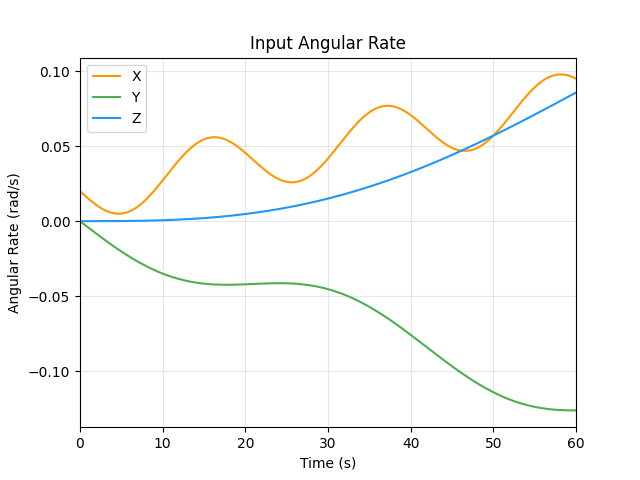

In [4]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# All rights reserved.
# Do not use or redistribute without permission.
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np

from inertialsim import plot
from inertialsim.geometry import Vector
from inertialsim.time import span

# Create a time 0:60s time vector sampled at 10Hz
time = span(start=0.0, end=60.0, dt=0.1)

# Create a 3-axis sinusoidal signal with arbitrary frequency and phase.
# Inputs must always be 3-axis.  Set them to zero if needed.
angular_rate = np.zeros((time.size, 3, 1))
angular_rate[:, 0:1] = 0.001 * time - 0.02 * np.sin(0.3 * time) + 0.02
angular_rate[:, 1:2] = -0.002 * time + 0.015 * np.sin(-0.15 * time)
angular_rate[:, 2:3] = 0.0015 * time - 0.03 * np.sin(0.05 * time)
rate_vector = Vector.from_cartesian(angular_rate, time)

# Plot the input
rate_plot = plot.TimeSeries(title="Input Angular Rate", ylabel="Angular Rate (rad/s)")
rate_plot.line(time, angular_rate, xlimits=[0, 60])
rate_plot.legend(["X", "Y", "Z"])

## Simulate an ideal gyro measuring the input

Next we simulate an ideal single-axis gyro measuring the input.  An ideal gyro
is one with no sources of error.  By default, a single-axis sensor will measure
the `x-axis` input but this can be modified as shown below.  In this case we
simulate a gyro that is sensitive only along the `y-axis` input.

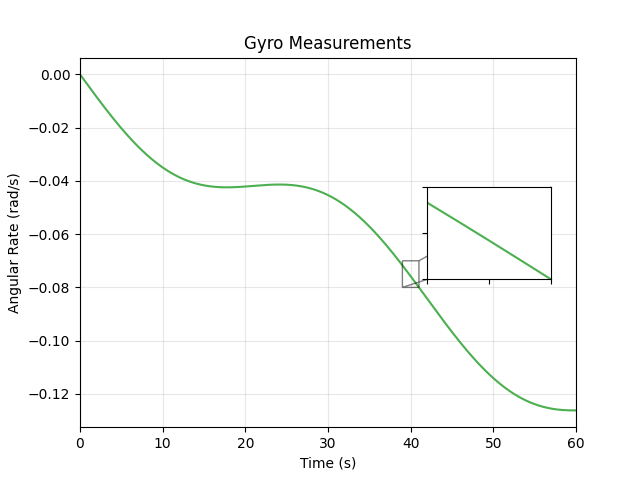

In [5]:
from inertialsim.sensors import Parameter, SensorModel
from inertialsim.sensors.gyro import Gyro, GyroSpecification

# Create a gyro model and keep the input sampling rate (10Hz) rather than using
# the Analog Devices sampling rate (125Hz).
model = SensorModel()
model.data_interface.simulate_sample_rate = False

# Create the single-axis gyro with a sensitive axis along the y input reference
# axis.
specification = GyroSpecification(axes=1)
specification.misalignment.fixed = Parameter([0, 1, 0], "dimensionless")

gyro = Gyro(model, specification, rng=0)
result = gyro.simulate(angular_rate=rate_vector)

# Plot the gyro measurements
rate_plot = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
rate_plot.line(time, result.angular_rate.data, xlimits=[0, 60], color="#4CAF50")
rate_plot.zoom_inset([0.7, 0.4, 0.25, 0.25], [39, 41], [-0.08, -0.07])

As can be seen, the measured output matches the `y-axis` input exactly.

## Simulate a realistic gyro

Next we create a realistic gyro using the [Analog Devices
ADIS16495][inertialsim.devices.analog_devices_adis16495] specification from the
InertialSim [devices][inertialsim.devices] library.  It is a 3-axis sensor.  By
default axes have a one-to-one alignment with the input.  In this case, each
axis has the same performance specifications but this is not always the case.

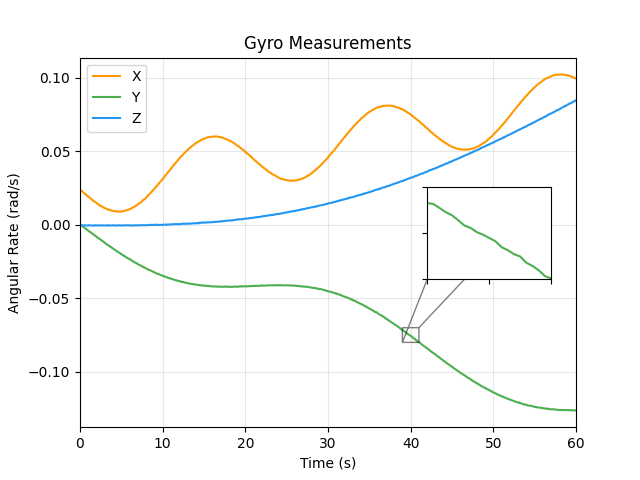

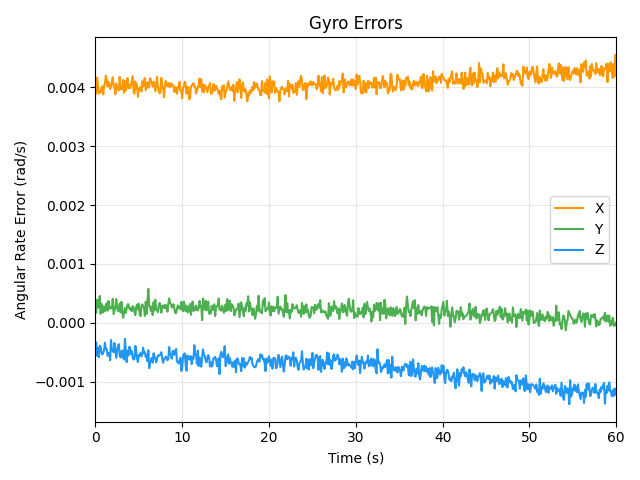

In [8]:
from inertialsim.devices import analog_devices_adis16495

# Create a gyro model and keep the input sampling rate (10Hz) rather than using
# the Analog Devices sampling rate (125Hz).
model = SensorModel()
model.data_interface.simulate_sample_rate = False

# Create the gyro and simulate the output
gyro = Gyro(model, specification=analog_devices_adis16495, rng=3)
result = gyro.simulate(angular_rate=rate_vector)

# Plot the gyro measurements
rate_plot = plot.TimeSeries(title="Gyro Measurements", ylabel="Angular Rate (rad/s)")
rate_plot.line(time, result.angular_rate.data, xlimits=[0, 60])
rate_plot.zoom_inset([0.7, 0.4, 0.25, 0.25], [39, 41], [-0.08, -0.07])
rate_plot.legend(["X", "Y", "Z"])

# Plot the error in measuring the input.  More precise error data can also be
# found in the result.metadata fields.
error_plot = plot.TimeSeries(title="Gyro Errors", ylabel="Angular Rate Error (rad/s)")
error_plot.line(time, result.angular_rate.data - angular_rate, xlimits=[0, 60])
error_plot.legend(["X", "Y", "Z"])
error_plot.figure.set_layout_engine("tight")

## Analyzing the result

The angular rate errors display the expected trends given the [Analog Devices
ADIS16495][inertialsim.devices.analog_devices_adis16495] specification.  Random
noise, bias (zero-offset), and drift are all observed. The total error is a
superposition of deterministic and random components so running the simulation
again (with a different `rng` input) will produce different results.